In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python --version

Python 3.7.10


In [3]:
pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=c6006aacbea82410634d67c460d4af526f30da6b62e8e9ebe5dd06145679cd4f
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [4]:
pip install pydicom

     |████████████████████████████████| 1.9MB 17.4MB/s 


In [5]:
import os
import re
import shutil
import pydicom
import pytesseract
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score

In [6]:
count = 0
for r,d,f in os.walk("/content/drive/MyDrive/Data_testing"):
  for file in f:
    if ".dcm" in file:
      count += 1
print("Total number of DICOM files:", count)

Total number of DICOM files: 2116


In [7]:
data = pydicom.dcmread("/content/drive/MyDrive/Data_testing/0-002 _002/1.2.840.113654.2.70.1.272234866199386504052807420495208842726/Bladder/Sagittal/1.2.840.113654.2.70.1.162524936614728192684386116639330353731.dcm")
np.max(data.pixel_array)


254

In [8]:
manufacturers = []
for r,d,f in os.walk("/content/drive/MyDrive/Data_testing"):
  for file in f:
    if ".dcm" in file:
      data = pydicom.dcmread(os.path.join(r,file))
      manufacturer = data.Manufacturer
      manufacturers.append(manufacturer)
results = set(manufacturers)
print(results)

{'Philips Medical Systems', 'SIEMENS', 'ATL'}


In [9]:
kidney_path = []
for r,d,f in os.walk("/content/drive/MyDrive/Data_testing"):
  for directory in d:
    if directory == "Kidney":
      kidney_path.append(os.path.join(r,directory))

kidney_files = []
for path in kidney_path:
  for r,d,f in os.walk(path):
    for file in f:
      if ".dcm" in file:
        kidney_files.append(os.path.join(r,file))

In [10]:
bladder_path = []
for r,d,f in os.walk("/content/drive/MyDrive/Data_testing"):
  for directory in d:
    if directory == "Bladder":
      bladder_path.append(os.path.join(r,directory))

bladder_files = []
for path in bladder_path:
  for r,d,f in os.walk(path):
    for file in f:
      if ".dcm" in file:
        bladder_files.append(os.path.join(r,file))

In [11]:
tot_num = len(kidney_files)+len(bladder_files)
df = pd.DataFrame(index=range(0,tot_num), columns=["image_name","Kidney", "Bladder", "Sagittal", "Transverse"])
print(df)
print("Total:", tot_num)

     image_name Kidney Bladder Sagittal Transverse
0           NaN    NaN     NaN      NaN        NaN
1           NaN    NaN     NaN      NaN        NaN
2           NaN    NaN     NaN      NaN        NaN
3           NaN    NaN     NaN      NaN        NaN
4           NaN    NaN     NaN      NaN        NaN
...         ...    ...     ...      ...        ...
1942        NaN    NaN     NaN      NaN        NaN
1943        NaN    NaN     NaN      NaN        NaN
1944        NaN    NaN     NaN      NaN        NaN
1945        NaN    NaN     NaN      NaN        NaN
1946        NaN    NaN     NaN      NaN        NaN

[1947 rows x 5 columns]
Total: 1947


In [12]:
for idx in range(len(kidney_files)):
  n = kidney_files[idx]
  df['image_name'][idx] = n

  if "Kidney" in n:
    df['Kidney'][idx] = 1
  else:
    df['Kidney'][idx] = 0

  if "Bladder" in n:
    df['Bladder'][idx] = 1
  else:
    df['Bladder'][idx] = 0

  if "Sagittal" in n:
    df['Sagittal'][idx] = 1
  else:
    df['Sagittal'][idx] = 0

  if "Transverse" in n:
    df['Transverse'][idx] = 1
  else:
    df['Transverse'][idx] = 0

num_end = idx + 1

In [13]:
for idx in range(len(bladder_files)):
  n = bladder_files[idx]
  df['image_name'][num_end+idx] = n
  
  if "Kidney" in n:
    df['Kidney'][num_end+idx] = 1
  else:
    df['Kidney'][num_end+idx] = 0

  if "Bladder" in n:
    df['Bladder'][num_end+idx] = 1
  else:
    df['Bladder'][num_end+idx] = 0

  if "Sagittal" in n:
    df['Sagittal'][num_end+idx] = 1
  else:
    df['Sagittal'][num_end+idx] = 0

  if "Transverse" in n:
    df['Transverse'][num_end+idx] = 1
  else:
    df['Transverse'][num_end+idx] = 0

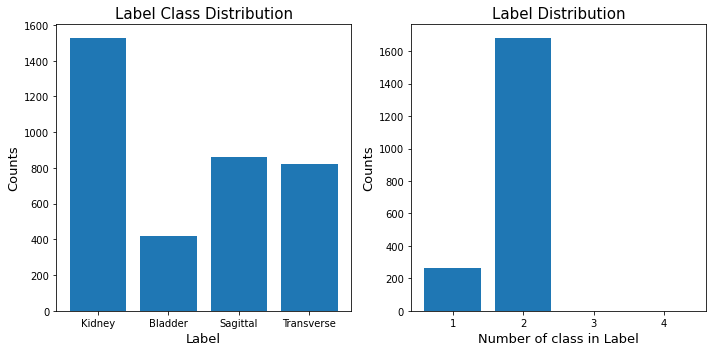

In [23]:
df2 = df
df2 = df2.drop(columns=['image_name'], axis=1)
labels = ['Kidney','Bladder','Sagittal','Transverse']
values = []
value = df2.sum(axis=0)
for name in labels:
  values.append(value[name])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(labels, values)
plt.title('Label Class Distribution', fontsize=15)
plt.xlabel('Label', fontsize=13)
plt.ylabel('Counts', fontsize=13)

a = 0
b = 0 
result = []
for idx in range(len(df2)):
  if sum(df2.iloc[idx].values) == 1:
    a += 1
  else:
    b += 1
result.append(a)
result.append(b)
result.append(0)
result.append(0)

label = ["1","2","3","4"]
plt.subplot(1,2,2)
plt.bar(label, result)
plt.title('Label Distribution', fontsize=15)
plt.xlabel('Number of class in Label', fontsize=13)
plt.ylabel('Counts', fontsize=13)
plt.tight_layout()

Text(0, 0.5, 'Counts')

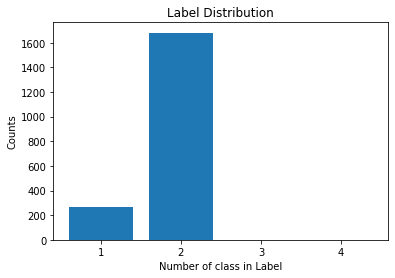

In [17]:
a = 0
b = 0 
result = []
for idx in range(len(df2)):
  if sum(df2.iloc[idx].values) == 1:
    a += 1
  else:
    b += 1
result.append(a)
result.append(b)
result.append(0)
result.append(0)

label = ["1","2","3","4"]
plt.bar(label, result)
plt.title('Label Distribution')
plt.xlabel('Number of class in Label')
plt.ylabel('Counts')

In [ ]:
df.to_csv("/content/drive/MyDrive/Data_testing/file_names.csv",index=False)

In [ ]:
df